In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import category_encoders as ce
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score,precision_recall_curve
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from category_encoders.binary import BinaryEncoder
import category_encoders as ce
import pickle
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from itertools import combinations 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate

from transformers import (
    Test, 
    CreateCyclicalFeatures, 
    CategoricalDataCleaning, 
    NumericalDataCleaning
)

RANDOM_STATE = 1

In [2]:
path = os.path.join('data', 'train.csv')
train_df = pd.read_csv(path)
train_df = train_df.drop_duplicates()
train_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,10/01/2013 12:00:00 AM,NEW HAVEN,V,262,True,N,Stop Sign,31.0,H,W,M,True
1,False,False,State Police,10/01/2013 12:00:00 AM,WILLINGTON,V,1000002715,False,N,Other,29.0,M,W,M,False
2,False,False,Plymouth,10/01/2013 12:00:00 AM,Terryville,V,21,True,N,Speed Related,18.0,N,W,M,True
3,False,False,Plymouth,10/01/2013 12:00:00 AM,Plymouth,V,D1,True,N,Speed Related,52.0,N,W,F,False
4,False,False,Bethel,10/01/2013 12:00:00 AM,BETHEL,V,08M,True,N,Cell Phone,34.0,N,W,M,False


In [3]:
train_df['InterventionDateTime'] = pd.to_datetime(train_df['InterventionDateTime'], format='%m/%d/%Y %I:%M:%S %p')
train_df = train_df.sort_values(by=['InterventionDateTime'])
# Removing the observations of cars that were not searched
train_df = train_df[train_df.VehicleSearchedIndicator == True]
X_all, y_all = train_df.drop(columns = ['VehicleSearchedIndicator', 'ContrabandIndicator']), train_df.ContrabandIndicator.copy()
#Categorical columns to perform the encoding
cat_columns = ['Department Name', 'InterventionLocationName', 'InterventionReasonCode', 
                          'SearchAuthorizationCode', 'StatuteReason', 
                          'ReportingOfficerIdentificationID']
pipeline = make_pipeline(
    CreateCyclicalFeatures(),
    CategoricalDataCleaning(),
    NumericalDataCleaning(),
    BinaryEncoder(cols=cat_columns),
    # Test is just a debugging class
    Test(),
    RandomForestClassifier(n_estimators = 150 ,max_depth = 9, min_samples_split = 5, 
                           random_state=RANDOM_STATE)
    )

train_results = []
test_results = []
cv = TimeSeriesSplit(n_splits=3)
for ii, (train, test) in enumerate(cv.split(X_all, y_all)):
    pipeline.fit(X_all[min(train):max(train)], y_all[min(train):max(train)])
    X_train_pred = pipeline.predict(X_all[min(train):max(train)])
    X_test_pred = pipeline.predict(X_all[min(test):max(test)])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_all[min(train):max(train)], X_train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_all[min(test):max(test)], X_test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    if max(train) == 17471: #This means that we are in the first folder, the only one that has middle east values
        probas = pipeline.predict_proba(X_all[min(test):max(test)])
        a = y_all[min(test):max(test)]
        b = X_all[min(test):max(test)]
        precision_middle_east, recall_middle_east, thresholds_middle_east = \
        precision_recall_curve(a[np.equal(b.SubjectEthnicityCode, 'M')], 
                               probas[:, 1][np.equal(b.SubjectEthnicityCode, 'M')])

print(train_results)
print(test_results)

51
51
51
51
52
52
52
53
53
53
[0.7132491870459714, 0.7019904862454606, 0.6961178950896635]
[0.6431914276029075, 0.6762187479702569, 0.6686242571070677]


In [5]:
with open('columns.json', 'w') as fh:
    json.dump(X_all.columns.tolist(), fh)

In [6]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_all.dtypes, fh)

In [7]:
pipeline.fit(X_all, y_all)
from sklearn.externals import joblib
joblib.dump(pipeline, 'pipeline.pickle')

53


C:\Anaconda3\envs\final_test\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['pipeline.pickle']

old code used for features importances analysis

In [8]:
'''pd.Series(pipeline[5].feature_importances_, index=['Department Name', 'InterventionLocationName', 'InterventionReasonCode',
       'ReportingOfficerIdentificationID',
       'SearchAuthorizationCode', 'StatuteReason', 'SubjectAge',
       'SubjectRaceCode',
       'TownResidentIndicator', 'InterventionDateYear',
       'InterventionDateMonth_sin', 'InterventionDateMonth_cos',
       'InterventionDateDay_sin', 'InterventionDateDay_cos',
       'InterventionDateHour_sin', 'InterventionDateHour_cos']).nlargest(20).plot.barh();'''

"pd.Series(pipeline[5].feature_importances_, index=['Department Name', 'InterventionLocationName', 'InterventionReasonCode',\n       'ReportingOfficerIdentificationID',\n       'SearchAuthorizationCode', 'StatuteReason', 'SubjectAge',\n       'SubjectRaceCode',\n       'TownResidentIndicator', 'InterventionDateYear',\n       'InterventionDateMonth_sin', 'InterventionDateMonth_cos',\n       'InterventionDateDay_sin', 'InterventionDateDay_cos',\n       'InterventionDateHour_sin', 'InterventionDateHour_cos']).nlargest(20).plot.barh();"

In [9]:
#Equivalent to the last folder of the CV
X_train, y_train, X_test, y_test = X_all[0:52409], y_all[0:52409], X_all[52409:], y_all[52409:]

In [10]:
probas = pipeline.predict_proba(X_test)

53


In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, probas[:, 1])

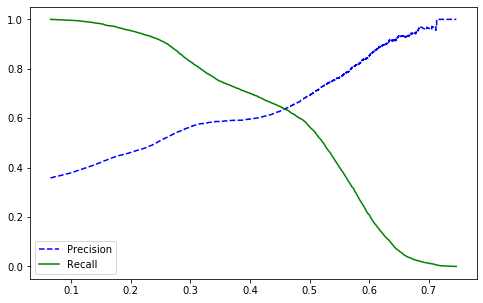

In [12]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [13]:
thresholds

array([0.06553742, 0.06555829, 0.06560901, ..., 0.74174974, 0.74504174,
       0.74606874])

In [14]:
thresholds[np.greater_equal(precision, [0.5])[:-1]][0]

0.242740481467374

So, with 0.24 we get 0.5 precision!

In [16]:
precision_female, recall_female, thresholds_female = precision_recall_curve(y_test[np.equal(X_test.SubjectSexCode, 'F')], probas[:, 1][np.equal(X_test.SubjectSexCode, 'F')])
precision_male, recall_male, thresholds_male = precision_recall_curve(y_test[np.equal(X_test.SubjectSexCode, 'M')], probas[:, 1][np.equal(X_test.SubjectSexCode, 'M')])
precision_hispanic, recall_hispanic, thresholds_hispanic = precision_recall_curve(y_test[np.equal(X_test.SubjectEthnicityCode, 'H')], probas[:, 1][np.equal(X_test.SubjectEthnicityCode, 'H')])
precision_not_applicable_ethnicity, recall_not_applicable_ethnicity, thresholds_not_applicable_ethnicity = precision_recall_curve(y_test[np.equal(X_test.SubjectEthnicityCode, 'N')], probas[:, 1][np.equal(X_test.SubjectEthnicityCode, 'N')])
precision_white, recall_white, thresholds_white= precision_recall_curve(y_test[np.equal(X_test.SubjectRaceCode, 'W')], probas[:, 1][np.equal(X_test.SubjectRaceCode, 'W')])
precision_black, recall_black, thresholds_black= precision_recall_curve(y_test[np.equal(X_test.SubjectRaceCode, 'B')], probas[:, 1][np.equal(X_test.SubjectRaceCode, 'B')])
precision_indian, recall_indian, thresholds_indian= precision_recall_curve(y_test[np.equal(X_test.SubjectRaceCode, 'I')], probas[:, 1][np.equal(X_test.SubjectRaceCode, 'I')])
precision_asian, recall_asian, thresholds_asian= precision_recall_curve(y_test[np.equal(X_test.SubjectRaceCode, 'A')], probas[:, 1][np.equal(X_test.SubjectRaceCode, 'A')])

In [17]:
thresholds_indian

array([0.22657764, 0.23267617, 0.24756288, 0.25085816, 0.25086909,
       0.25154629, 0.25342739, 0.26675592, 0.27241176, 0.27370582,
       0.28083783, 0.28207488, 0.28446325, 0.28814097, 0.30375721,
       0.30393912, 0.31326029, 0.31721089, 0.32274018, 0.33251438,
       0.33539683, 0.34711473, 0.39053937, 0.39638796, 0.41996876,
       0.42221221, 0.46963888, 0.48369725, 0.50690828, 0.50715849,
       0.51380715, 0.51440542, 0.51869121, 0.52017276, 0.52624093,
       0.55023112, 0.55829765, 0.5645937 , 0.56762403, 0.56925506,
       0.56994525, 0.57595202, 0.59413466, 0.59803621, 0.60047224,
       0.61279115, 0.63612523, 0.63755862, 0.63983411, 0.64371323,
       0.68765107])

Thresholds for the indian class end at 0.68!

In [29]:
min_descrepancy = 1
for i in thresholds[np.greater_equal(precision, [0.5])[:-1]]: 
    if i <= 0.68765107: 
#the <= part is because the threholds of the indian class only go until 0.8. At 0.8, recall of the indian class is 0
        test_list = [precision_male[:-1][np.greater_equal(thresholds_male, [i])][0], 
                     precision_female[:-1][np.greater_equal(thresholds_female, [i])][0]]
        test_list_2 = [precision_hispanic[:-1][np.greater_equal(thresholds_hispanic, [i])][0],
                       precision_middle_east[:-1][np.greater_equal(thresholds_middle_east, [i])][0],
                      precision_not_applicable_ethnicity[:-1][np.greater_equal(thresholds_not_applicable_ethnicity, [i])][0]]
        test_list_3 = [precision_white[:-1][np.greater_equal(thresholds_white, [i])][0],
                      precision_black[:-1][np.greater_equal(thresholds_black, [i])][0],
                      precision_indian[:-1][np.greater_equal(thresholds_indian, [i])][0],
                      precision_asian[:-1][np.greater_equal(thresholds_asian, [i])][0]]

        res = max(combinations(test_list, 2), key = lambda sub: abs(sub[0]-sub[1]))
        res_2 = max(combinations(test_list_2, 2), key = lambda sub: abs(sub[0]-sub[1]))
        res_3 = max(combinations(test_list_3, 2), key = lambda sub: abs(sub[0]-sub[1]))
        descrepancy_sex = abs(res[0]-res[1])
        descrepancy_ethnicity = abs(res_2[0]-res_2[1])
        descrepancy_race = abs(res_3[0]-res_3[1])
        if max(descrepancy_sex, descrepancy_ethnicity, descrepancy_race) < min_descrepancy:
            min_descrepancy = max(descrepancy_sex, descrepancy_ethnicity, descrepancy_race)
            thresh = i
print(min_descrepancy)
print(thresh)

0.06812983425203534
0.3873617971247522


So the threshold that minimizes the descrepancy between classes is 0.39!

In [24]:
precision[:-1][np.greater_equal(thresholds, [0.3873617971247522])][0]

0.5920553145336226

In [25]:
recall[:-1][np.greater_equal(thresholds, [0.3873617971247522])][0]

0.7122818463545915

Sweet precision and recall values eheh

In [26]:
i = 0.3873617971247522
test_list = [precision_male[:-1][np.greater_equal(thresholds_male, [i])][0], 
                     precision_female[:-1][np.greater_equal(thresholds_female, [i])][0]]
test_list_2 = [precision_hispanic[:-1][np.greater_equal(thresholds_hispanic, [i])][0],
               precision_middle_east[:-1][np.greater_equal(thresholds_middle_east, [i])][0],
                      precision_not_applicable_ethnicity[:-1][np.greater_equal(thresholds_not_applicable_ethnicity, [i])][0]]
test_list_3 = [precision_white[:-1][np.greater_equal(thresholds_white, [i])][0],
                      precision_black[:-1][np.greater_equal(thresholds_black, [i])][0],
                      precision_indian[:-1][np.greater_equal(thresholds_indian, [i])][0],
                      precision_asian[:-1][np.greater_equal(thresholds_asian, [i])][0]]
print(test_list)
print(test_list_2)
print(test_list_3)
res = max(combinations(test_list, 2), key = lambda sub: abs(sub[0]-sub[1]))
res_2 = max(combinations(test_list_2, 2), key = lambda sub: abs(sub[0]-sub[1]))
res_3 = max(combinations(test_list_3, 2), key = lambda sub: abs(sub[0]-sub[1]))
descrepancy_sex = abs(res[0]-res[1])
descrepancy_ethnicity = abs(res_2[0]-res_2[1])
descrepancy_race = abs(res_3[0]-res_3[1])
print(descrepancy_sex)
print(descrepancy_ethnicity)
print(descrepancy_race)

[0.5940860215053764, 0.5835674157303371]
[0.5664993726474279, 0.5945945945945946, 0.5991006572120373]
[0.6146751383480221, 0.5465453040959868, 0.5517241379310345, 0.6078431372549019]
0.01051860577503927
0.03260128456460942
0.06812983425203534


So above we can see the descrepancy values and the precision individual values for all the classes and categories